In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from yass.augment import make
from pathlib import Path

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate

import seaborn as sns
import pandas as pd
from dstools import plot

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

In [62]:
def predict(x, predict_function):
    return ['{:.2f}'.format(p) for p in predict_function(x)]

def shifter_generator(x, waveform_length, step):
    original_wf_length, n_channels = x.shape    
    n = int((original_wf_length - waveform_length)/step + 1)

    shifted = np.zeros((n, waveform_length, n_channels))
    
    for i in range(n):
        shifted[i, :, :] = x[(i * step):waveform_length + (i * step), :]
    
    return shifted

def predict_plot(model, x, elements=None):
    
    preds = predict(x, model.predict)

    plot.grid_from_array(x,
                         axis=0,
                         auto_figsize=3,
                         labels=preds,
                         elements=elements)


def shift_predict_plot(x, waveform_length, step, model):
    shifted = shifter_generator(x, waveform_length, step)
    predict_plot(model, shifted)

In [69]:
path_to_model = '/home/Edu/dev/private-yass/nnet/models/triage/27-Jul-2018@13-14-29.ckpt'
model = NeuralNetTriage.load(path_to_model, 0.5, load_test_set=True)

INFO:yass.neuralnetwork.model:Loading x_test at /home/Edu/dev/private-yass/nnet/models/triage/27-Jul-2018@13-14-29-x-test.npy
INFO:yass.neuralnetwork.model:Loading y_test at /home/Edu/dev/private-yass/nnet/models/triage/27-Jul-2018@13-14-29-y-test.npy


## Evaluation on test set

In [70]:
y_pred = model.predict(model.x_test)
y_true = model.y_test

print(metrics.classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.94      0.83      0.88      6047
        1.0       0.85      0.95      0.90      5958

avg / total       0.90      0.89      0.89     12005



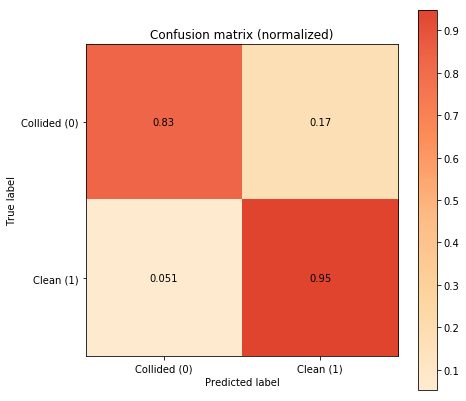

In [71]:
plt.rcParams['figure.figsize'] = (7, 7)
sk_plot.confusion_matrix(y_true, y_pred, target_names=['Collided (0)', 'Clean (1)'],
                        normalize=True)

In [72]:
_ = metrics.confusion_matrix(y_true, y_pred)
cm = _ / _.sum(axis=1)
tn, fp, fn, tp = cm.flatten()
tn, fp, fn, tp

(0.8329750289399702,
 0.16951997314535078,
 0.05043823383495948,
 0.9488083249412554)

In [73]:
metrics.accuracy_score(y_true, y_pred)

0.8904623073719283

In [74]:
metrics.f1_score(y_true, y_pred)

0.8958085730132319

In [75]:
metrics.recall_score(y_true, y_pred)

0.9488083249412554

In [76]:
metrics.precision_score(y_true, y_pred)

0.8484166291460303

In [77]:
clean = model.x_test[model.y_test == 1]
collided = model.x_test[model.y_test == 0]

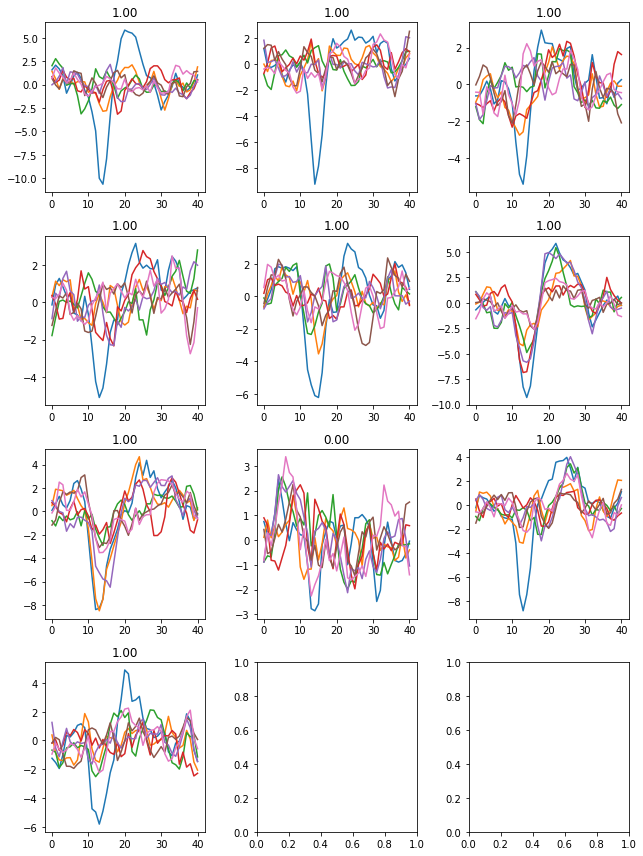

In [78]:
predict_plot(model, clean, elements=10)

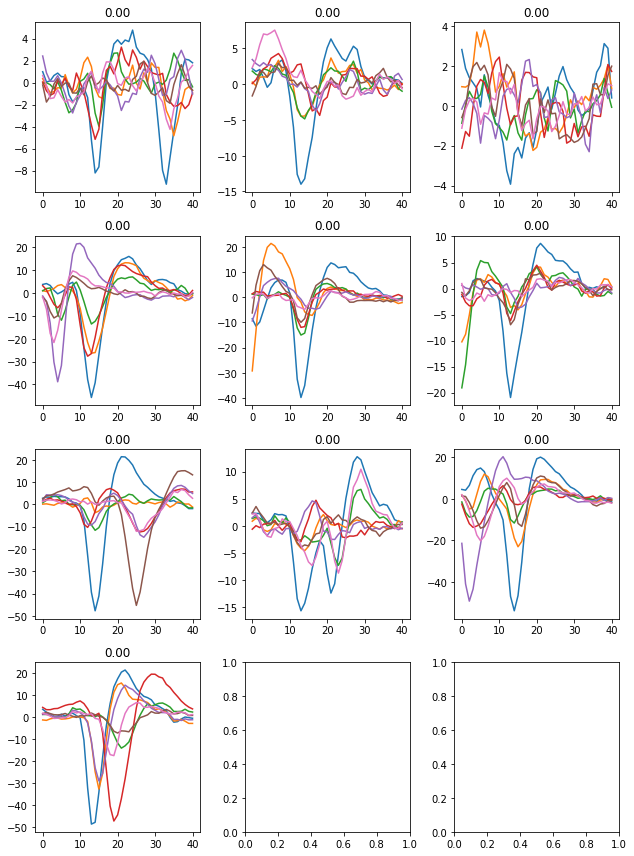

In [15]:
predict_plot(model, collided, elements=10)

## Generate data for evaluation

In [102]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 2
max_amp = 20
n_clean_per_template = 20


path_to_standarized = str(Path('~/data/tmp/preprocess/standarized.bin').expanduser())

n_templates = np.max(spike_train[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [103]:
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train, path_to_standarized)

INFO:yass.templates.util:Computing templates...
INFO:yass.batch.batch:Applying function yass.templates.util.compute_weighted_templates...
100%|██████████| 3/3 [00:14<00:00,  4.80s/it]
INFO:yass.batch.batch:yass.templates.util.compute_weighted_templates took 14.4049 seconds


In [104]:
templates = (processor.align(CONFIG.spike_size)
                      .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
                      .crop_temporally(20).values)

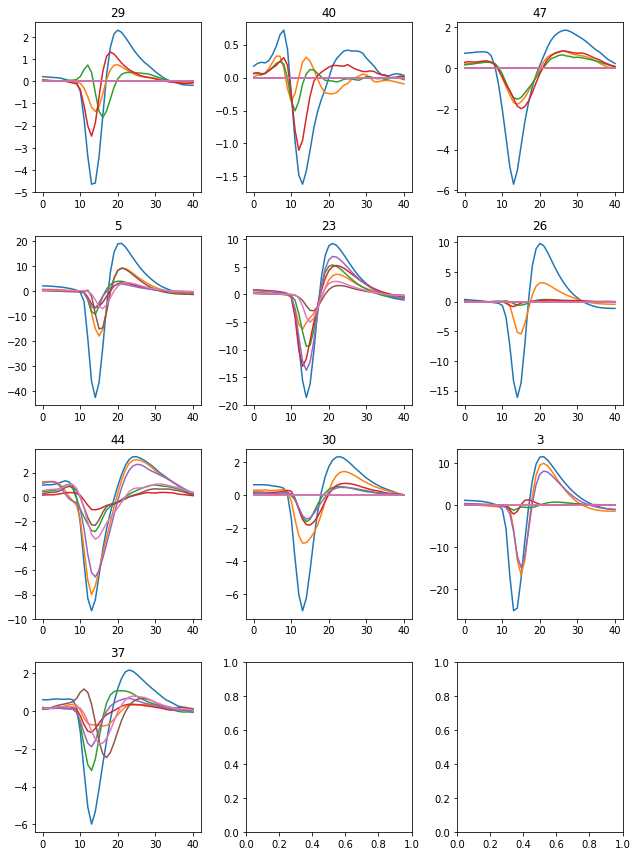

In [105]:
plot.grid_from_array(templates, axis=0, max_cols=3,
                     auto_figsize=3, elements=10)

In [106]:
dataset = Dataset.make(2, templates,
                       min_amp, max_amp,
                       path_to_standarized,
                       n_clean_per_template,
                       CONFIG.geom,
                       make_from_templates=True,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=True,
                       make_noise=False)

In [107]:
from_templates = dataset.get_kind('from templates').data_noisy
collided = dataset.get_kind('collided').data_noisy

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


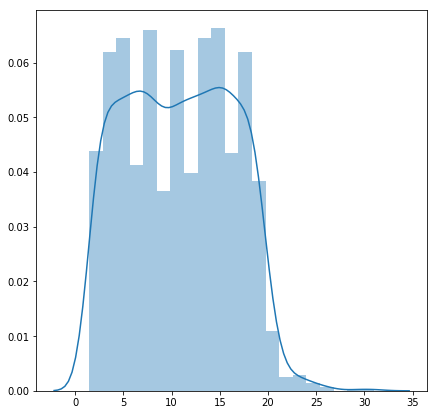

In [108]:
sns.distplot(dataset.amplitudes)

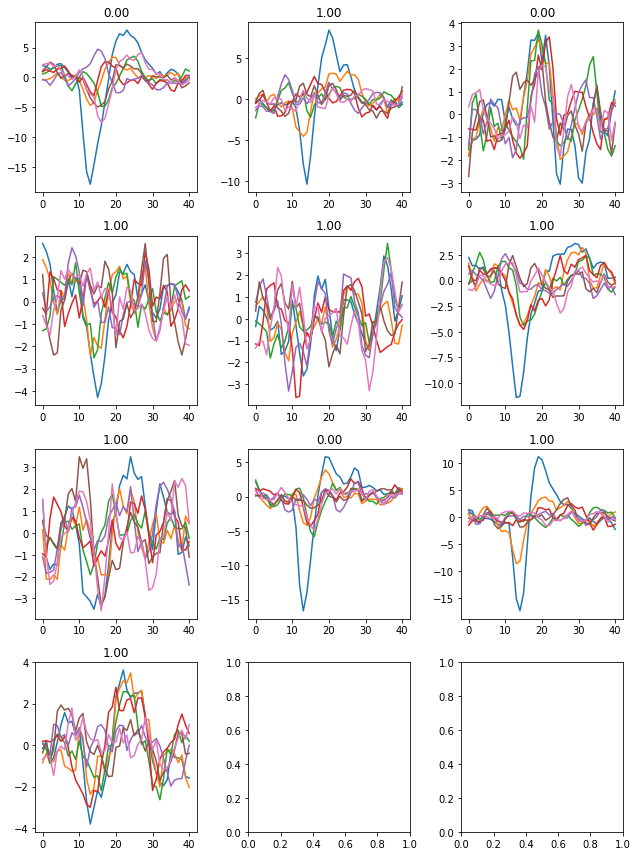

In [109]:
predict_plot(model, from_templates, 10)

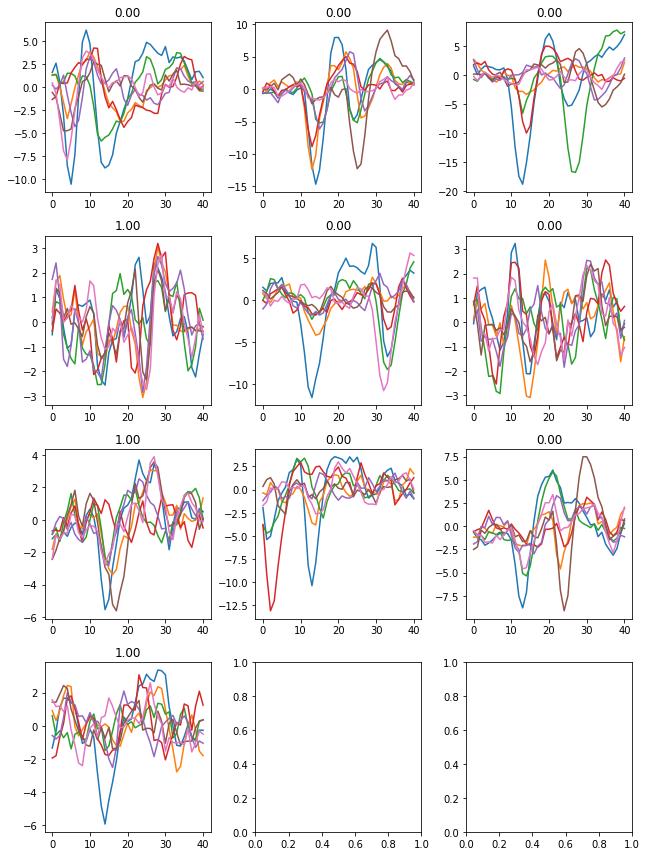

In [110]:
predict_plot(model, collided, 10)

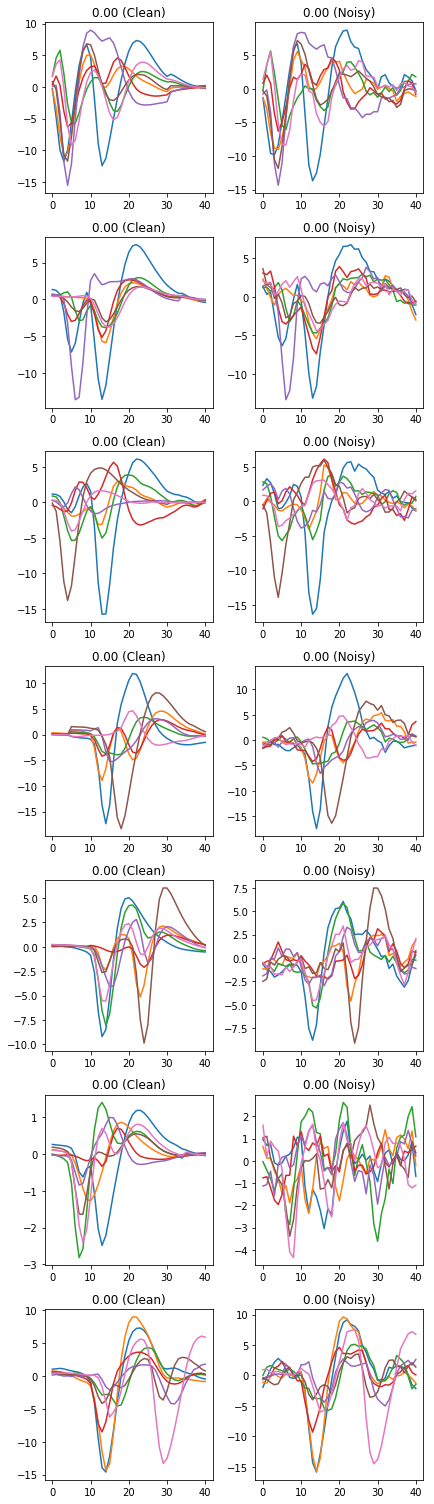

In [111]:
_ = dataset.get_kind('collided')

preds = predict(_.data_noisy, model.predict)

plot.grid_from_array([_.data_clean, _.data_noisy],
             axis=0,
             elements=7,
             group_names=('Clean', 'Noisy'),
             labels=preds,
             auto_figsize=3)

## Metrics for different SNR

In [112]:
def process_group(group_id, group, predict_function, metric_fn):
    """Process a single group in a dataframe
    """
    # get waveforms
    wfs = np.stack(group.waveform.values, axis=0)
    
    # make predictions
    preds = predict_function(wfs)
    
    # compute metric
    metric = metric_fn(preds, group)

    return group_id, metric

def compute_per_group(df, column, predict_function, metric_fn):
    """Compute a metric over groups in a dataframe
    """
    # group and compute proportion of correct predictions
    vals = [process_group(group_id, group, predict_function, metric_fn)
            for group_id, group
            in df.groupby(column)]

    group_ids, metric = list(zip(*vals))

    return group_ids, metric

In [113]:
dataset.df_noisy.head()

,waveform,amplitude,kind,amplitude_group
0,"[[0.8987943821455743, 0.4327087944792842, 0.76...",2.0,from templates,2.9
1,"[[-0.14122894936819191, 0.3292974339847481, -0...",2.9,from templates,2.9
2,"[[0.9302699515778946, -0.06657518245464382, 0....",3.8,from templates,3.8
3,"[[-0.34593243846465865, -0.02870952326481996, ...",4.7,from templates,5.6
4,"[[-1.7953185353402545, -0.8653536541409313, -0...",5.6,from templates,5.6


In [114]:
df = dataset.get_kind('collided').df_noisy

# add labels
_ = {'from templates': 1, 'collided': 0}

df['label'] = df.kind.replace(_)

df.head()

,waveform,amplitude,kind,amplitude_group,label
0,"[[1.1655654384111365, 0.43454438762893915, -0....",3.800000,collided,4.142,0
1,"[[-1.3008260155397795, -0.24614843738473785, -...",10.205807,collided,11.000,0
2,"[[-4.421772401876737, -1.9584848859046178, -2....",15.097929,collided,15.151,0
3,"[[0.76220810859373, -1.0288771110052348, 0.474...",4.644148,collided,5.600,0
4,"[[-0.22056415790658102, -1.6322805932730584, 0...",6.088146,collided,6.735,0


In [115]:
df.kind.unique()

array(['collided'], dtype=object)

In [116]:
def prop(preds, group):
    """Proportion of predictions with the correct label
    """
    return (preds == group.label).mean()

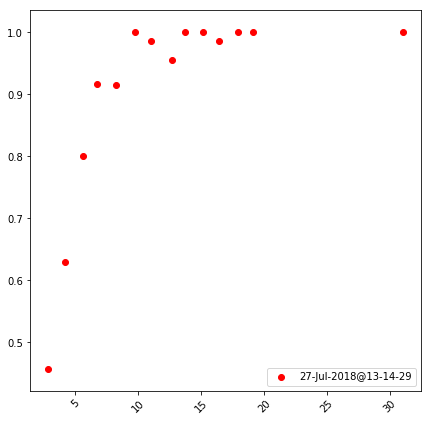

In [117]:
x, y = compute_per_group(df,
                         'amplitude_group',
                         model.predict, prop)

# plot results
_ = plt.scatter(x, y, color='r',
                label=model.model_name)

_ = plt.legend()
_ = plt.xticks(rotation=45)